### Predicting Health Insurance via Regression Models

###### Purpose: To predict customer healthcare costs using machine learning.
###### Datasets: insurance.csv- training data + validation_dataset.csv - testing dataset.


In [240]:
# import the required libraries.
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [241]:
# load the insurance dataset.
insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


#### Clean Up the Data.

In [242]:
# how many missing values are there?
insurance.isnull().sum()

age         66
sex         66
bmi         66
children    66
smoker      66
region      66
charges     54
dtype: int64

In [243]:
# Drop the missing values.
insurance = insurance.dropna()
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [244]:
# Standardise the information in the columns.
insurance["region"] = insurance["region"].str.lower()

In [245]:
# Standardize the gender into two categories.
FEMALE = "female"
MALE = "male"
sex_map = {'F': FEMALE, 'woman': FEMALE, 'M': MALE, 'man': MALE}

In [246]:
# Change the smoker column to a boolean value.
insurance['smoker']= (insurance['smoker']=='yes')

In [247]:
# Standardise charge data types.
insurance['charges']= insurance['charges'].str.strip('$')

In [248]:
# Convert the ages to positive.
insurance['age']= insurance['age'].abs()

In [249]:
# Change the index number. 
insurance_pos = insurance.apply(lambda x: x.abs() if np.issubdtype(x.dtype, np.number) else x)
insurance_pos.sample(10)

,age,sex,bmi,children,smoker,region,charges
406,33.0,female,24.310,0.0,False,southeast,4185.0979
602,56.0,female,25.300,0.0,False,southwest,11070.535
1002,24.0,M,25.800,0.0,False,southwest,1972.95
786,60.0,male,36.955,0.0,False,northeast,12741.16745
1041,18.0,male,23.085,0.0,False,northeast,1704.70015
1053,47.0,male,29.800,3.0,True,southwest,25309.489
636,19.0,female,24.510,1.0,False,northwest,2709.1119
206,59.0,male,26.400,0.0,False,southeast,11743.299
253,27.0,male,30.300,3.0,False,southwest,4260.744
70,27.0,female,24.750,0.0,True,southeast,16577.7795


##### Plot the data.

In [250]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Charges')

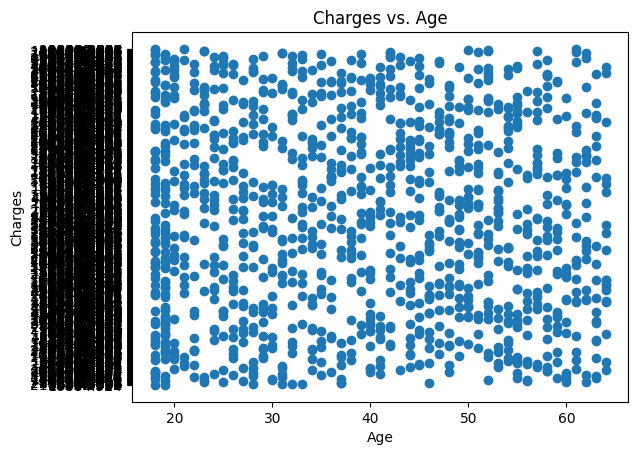

In [251]:
# scatterplot the relationship between age and charges.
x = insurance['age']
y = insurance['charges']

plt.scatter(x, y)

# add titles and axis labels.
plt.title("Charges vs. Age")
plt.xlabel("Age")
plt.ylabel("Charges")

Text(0, 0.5, 'Charges')

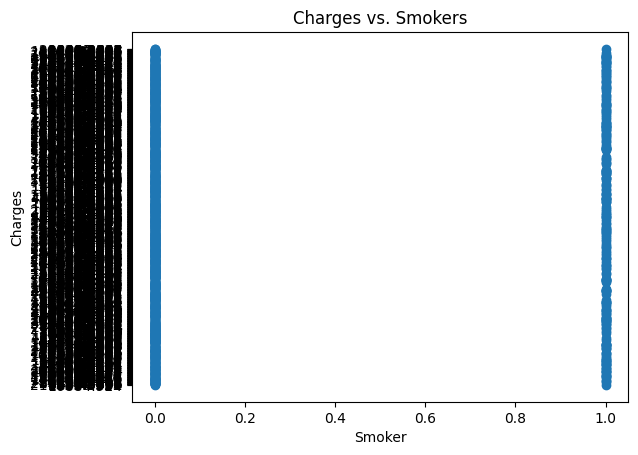

In [252]:
# scatterplot the relationship between smokers and charges.
x = insurance['smoker']
y = insurance['charges']

plt.scatter(x, y)

# add titles and axis labels.
plt.title("Charges vs. Smokers")
plt.xlabel("Smoker")
plt.ylabel("Charges")

#### Prepare the data for modelling

In [253]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1208 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1208 non-null   float64
 1   sex       1208 non-null   object 
 2   bmi       1208 non-null   float64
 3   children  1208 non-null   float64
 4   smoker    1208 non-null   bool   
 5   region    1208 non-null   object 
 6   charges   1208 non-null   object 
dtypes: bool(1), float64(3), object(3)
memory usage: 67.2+ KB


In [254]:
# Count the answers for region.
insurance['region'].value_counts()

region
southeast    322
southwest    297
northeast    295
northwest    294
Name: count, dtype: int64

In [255]:
# Create dummy variables for the column of region.
df_new = pd.get_dummies(insurance, prefix=['region'], columns=['region'])
df_new.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19.0,female,27.900,0.0,True,16884.924,False,False,False,True
1,18.0,male,33.770,1.0,False,1725.5523,False,False,True,False
2,28.0,male,33.000,3.0,False,4449.462,False,False,True,False
3,33.0,male,22.705,0.0,False,21984.47061,False,True,False,False
4,32.0,male,28.880,0.0,False,3866.8552,False,True,False,False


In [256]:
# Change the datatype for smokers to numerical values.
df_new['smoker']= df_new['smoker'].astype('int64')

In [257]:
# Create boolean for gender.
df_new['is_male'] = (df_new['sex']== 'male').astype('int64')

# Get rid of the gender column.
df_new = df_new.drop(columns=['sex'])

In [258]:
# Drop any missing values.
df_new = df_new.dropna()
df_new.head()

,age,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,is_male
0,19.0,27.900,0.0,1,16884.924,False,False,False,True,0
1,18.0,33.770,1.0,0,1725.5523,False,False,True,False,1
2,28.0,33.000,3.0,0,4449.462,False,False,True,False,1
3,33.0,22.705,0.0,0,21984.47061,False,True,False,False,1
4,32.0,28.880,0.0,0,3866.8552,False,True,False,False,1


In [259]:
# Replace NaN values in the charges column to 0. 
df_new['charges'] = df_new['charges'].replace(np.nan, 0)
df_new.head()

,age,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,is_male
0,19.0,27.900,0.0,1,16884.924,False,False,False,True,0
1,18.0,33.770,1.0,0,1725.5523,False,False,True,False,1
2,28.0,33.000,3.0,0,4449.462,False,False,True,False,1
3,33.0,22.705,0.0,0,21984.47061,False,True,False,False,1
4,32.0,28.880,0.0,0,3866.8552,False,True,False,False,1


In [260]:
# Change the datatype of 'charges' column from object to numercial
df_new['charges'] = df_new['charges'].apply(pd.to_numeric, errors='coerce')


In [261]:
# Have all the changes been successfully applied to the df_new?
df_new.info()
df_new.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1208 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1208 non-null   float64
 1   bmi               1208 non-null   float64
 2   children          1208 non-null   float64
 3   smoker            1208 non-null   int64  
 4   charges           1207 non-null   float64
 5   region_northeast  1208 non-null   bool   
 6   region_northwest  1208 non-null   bool   
 7   region_southeast  1208 non-null   bool   
 8   region_southwest  1208 non-null   bool   
 9   is_male           1208 non-null   int64  
dtypes: bool(4), float64(4), int64(2)
memory usage: 70.8 KB


,age,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,is_male
0,19.0,27.900,0.0,1,16884.92400,False,False,False,True,0
1,18.0,33.770,1.0,0,1725.55230,False,False,True,False,1
2,28.0,33.000,3.0,0,4449.46200,False,False,True,False,1
3,33.0,22.705,0.0,0,21984.47061,False,True,False,False,1
4,32.0,28.880,0.0,0,3866.85520,False,True,False,False,1


#### Build the Model

In [262]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [263]:
# Define the input and output variables.
X = df_new.drop(columns=['charges'])
y = df_new['charges']

# print(df_new.info())
print(y.info())

<class 'pandas.core.series.Series'>
Index: 1208 entries, 0 to 1337
Series name: charges
Non-Null Count  Dtype  
--------------  -----  
1207 non-null   float64
dtypes: float64(1)
memory usage: 18.9 KB
None


In [264]:
# Split the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)


In [265]:
# Create an instance of the Linear Regression class
model = LinearRegression()

In [266]:
# Train the model on the training set
model.fit(X_train, y_train)

ValueError: Input y contains NaN.

In [225]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [226]:
# Calculate the R squared score
r2_score = r2_score(y_test, y_pred)

In [227]:
# Output the mean squared error
r2_score

0.7128908906611219

#### Prepare the prediction set.

In [233]:
def preprocess_df(df):
    df_new = pd.get_dummies(df, prefix=['region'], columns=['region'])
    df_new = df_new.drop(columns=['region_southeast'])

    df_new['smoker']= (df_new['smoker'] == 'yes')
    df_new['smoker']= df_new['smoker'].astype('int64')

    df_new['is_male']= (df_new['sex'] == 'male').astype('int64')
    df_new = df_new.drop(columns=['sex'])
    
    return df_new

#### Implement the prediction set.

In [234]:
# Load the data file.
val_df = pd.read_csv('validation_dataset.csv')

In [236]:
# implement model creation
input_df = preprocess_df(val_df)

In [239]:
# Predictions
predictions = model.predict(input_df)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- region_southeast


In [269]:
# Validation
validation_data = val_df.copy()


In [274]:
validation_data['predicted_charges'] = predictions

NameError: name 'predictions' is not defined

In [273]:
validation_data.loc[validation_data['predicted_charges'] < 1000, 'predicted_charges'] = 1000

KeyError: 'predicted_charges'

In [272]:
validation_data.head()

,age,sex,bmi,children,smoker,region
0,18.0,female,24.090000,1.0,no,southeast
1,39.0,male,26.410000,0.0,yes,northeast
2,27.0,male,29.150000,0.0,yes,southeast
3,71.0,male,65.502135,13.0,yes,southeast
4,28.0,male,38.060000,0.0,no,southeast
